<a href="https://colab.research.google.com/github/mathewhall100/Aerial-cactus-identification/blob/master/Kaggle_Aerial_Cactus_Identification(V2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle:  Aerial cactus identification challenge.

 Aim is to identify the presence or absence of cacti in aerial photos as a tool to allow quantification of the effects of climate change on desert fauma over time.

The model achieved 99.6% accuracy on validation set data.

## Notebook setup

In [51]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install nbformat
!pip install nbconvert==5.4.1

     |████████████████████████████████| 409kB 3.4MB/s 
  Found existing installation: nbconvert 5.5.0
    Uninstalling nbconvert-5.5.0:
      Successfully uninstalled nbconvert-5.5.0


## Import Libraries

In [0]:
import os
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import accuracy

## Verify GPU status

In [3]:
print("GPU: ", torch.cuda.is_available())
print("Device = ", torch.device(torch.cuda.current_device()))
print("PyTorch version - ", torch.__version__)
print("Cuda version - ", torch.version.cuda)
print("cuDNN version - ", torch.backends.cudnn.version())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
Device =  cuda:0
PyTorch version -  1.1.0
Cuda version -  10.0.130
cuDNN version -  7501
python PIL version -  4.3.0


##Download competition dataset from Kaggle

In [5]:
!pip install kaggle
api_token = {"username":"mathewhall","key":"3cd933f5cc96d2233b1fc56d97ac0506"}
import json
import zipfile
# Create target Directory if doesn't exist
if not os.path.exists("/root/.kaggle"):
    os.mkdir("/root/.kaggle")
    print("Directory " , "/root/.kaggle" ,  " Created ")
else:    
    print("Directory " , "/root/.kaggle" ,  " already exists")
# Create kaggle.json file then write api_token into it
with open('/root/.kaggle/kaggle.json', 'w+') as file:
  json.dump(api_token, file)
# Important - change permissions of kaggle.json api_key not exposed to other users
!chmod 600 '/root/.kaggle/kaggle.json'

Directory  /root/.kaggle  Created 


In [6]:
# Copy api from kaggle.com dataset
!kaggle competitions download -c aerial-cactus-identification

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 92.0MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 45.2MB/s]
100% 4.20M/4.20M [00:00<00:00, 36.7MB/s]

 26% 5.00M/19.2M [00:00<00:00, 20.2MB/s]
100% 19.2M/19.2M [00:00<00:00, 55.2MB/s]


In [7]:
os.listdir()

['.config',
 'train.csv',
 'test.zip',
 'train.zip',
 'sample_submission.csv',
 'sample_data']

In [0]:
# Unzip all zipped files in the directory
for file in os.listdir():
  if zipfile.is_zipfile(file):
    zip_ref = zipfile.ZipFile(file,'r')
    zip_ref.extractall()
    zip_ref.close()

In [9]:
os.listdir()

['.config',
 'train',
 'train.csv',
 'test.zip',
 'test',
 'train.zip',
 'sample_submission.csv',
 'sample_data']

## Define parameters

In [0]:
bs = 64

In [0]:
data_path = "/content/"
data_path_train = data_path + "train/"
data_path_test = data_path + "test/"

## Load  data

In [0]:
df_train = pd.read_csv(data_path + 'train.csv')
df_test = pd.read_csv(data_path + 'sample_submission.csv')


In [0]:
df_train.head()

In [0]:
df_test.head()

## Create train_img and test_img objects

In [0]:
test_img = ImageList.from_df(df_test, path=data_path, folder='test')
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(df_train, path=data_path, folder='train')
        .split_by_rand_pct(0.2)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=128)
        .databunch(path='.', bs=64, device=torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

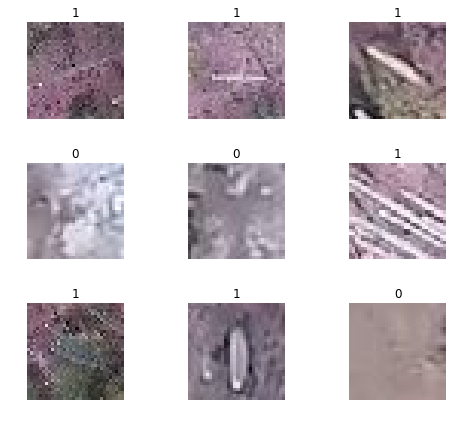

In [33]:
train_img.show_batch(rows=3, figsize=(7,6))


## Learn with resnet34

In [0]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])


In [0]:
learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


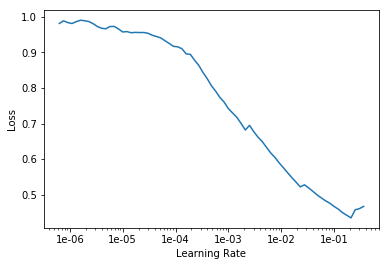

In [45]:
learn.lr_find()
learn.recorder.plot()

In [50]:
lr = 1e-02
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.038174,0.009410,0.003143,0.996857,01:32
1,0.015877,0.006764,0.001429,0.998571,01:26
2,0.009166,0.005002,0.001429,0.998571,01:25


## Save model "stage1"

In [0]:
learn.save('stage1')

## Analyse results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

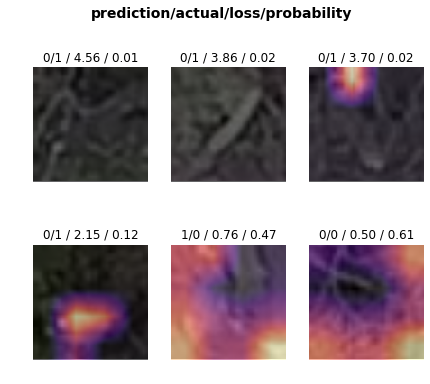

In [64]:
interp.plot_top_losses(6, figsize=(7,6))

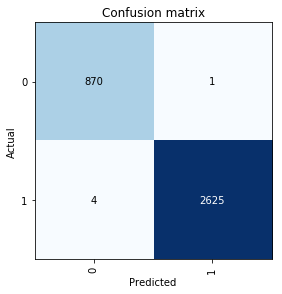

In [54]:
interp.plot_confusion_matrix()

## Predictions on test set

In [0]:
predictions = learn.get_preds(ds_type=DatasetType.Test)[0]

In [57]:
predictions[0]

tensor([3.7473e-07, 1.0000e+00])

In [58]:
predictions[:10]

tensor([[3.7473e-07, 1.0000e+00],
        [6.0103e-08, 1.0000e+00],
        [1.0000e+00, 2.5584e-07],
        [1.0000e+00, 1.1827e-11],
        [1.1931e-05, 9.9999e-01],
        [2.4139e-06, 1.0000e+00],
        [6.1211e-06, 9.9999e-01],
        [4.9699e-07, 1.0000e+00],
        [3.9831e-06, 1.0000e+00],
        [1.0000e+00, 3.3435e-09]])

In [0]:
predicted_classes = np.argmax(predictions, axis=1)

In [60]:
predicted_classes[:10]

tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

In [61]:
df_test['has_cactus'] = predicted_classes
df_test.head(10)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,1
7,0061bd302d735db829418cb90b4e6040.jpg,1
8,00754573d8c7223e73da553dd43780bd.jpg,1
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0
